# Face Generation
使用GANs生成新的人脸图像
### Get the Data
- MNIST
- CelebA

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST

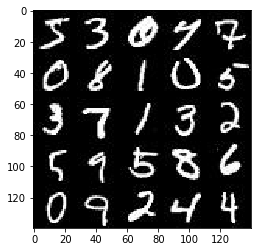

In [2]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
 [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

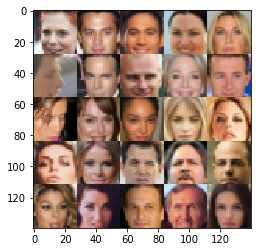

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset ： [-0.5, 0.5] 、 28x28   
The CelebA images ：先裁剪cropped，以除去不包括脸部的图像部分，然后调整为28x28.

The MNIST images :黑白图像、 a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) 

the CelebA images ： [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


###  model_inputs
Create TF Placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders:
- the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')


    return input_real, input_z, learning_rate


"""
check model_inputs
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

 Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused. 

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
        # when images is 28x28x3
        
        # conv1 --> output 14x14x128
        conv = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob=keep_prob)

         # conv2 --> output 7x7x256
        conv = tf.layers.conv2d(conv, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.layers.batch_normalization(conv, training=True)  # training=True--因为只想使用 D 来帮助训练 G
        conv = tf.maximum(alpha * conv, conv)   
        conv = tf.nn.dropout(conv, keep_prob=keep_prob)
 
        # conv3 --> output 4x4x512
        conv = tf.layers.conv2d(conv, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.layers.batch_normalization(conv, training=True)  # training=True--因为只想使用 D 来帮助训练 G
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob=keep_prob)
        
        # conv4--> output 4x4x512
        conv = tf.layers.conv2d(conv, 512, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob=keep_prob)

    
        # FC
        conv = tf.reshape(conv, (-1, 4*4*512))
        logits = tf.layers.dense(conv, 1, activation=None)
        out = tf.sigmoid(logits)

        
        

    return out, logits


"""
check discriminator
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator

In [7]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator -- 28 x 28 x `out_channel_dim` images
    """
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse=not is_train):  # 训练期间，不能 reuse变量
        
        # fc
        fc = tf.layers.dense(z, 7*7*512)
        fc = tf.reshape(fc, [-1, 7, 7, 512])
        fc = tf.layers.batch_normalization(fc, training=is_train)
        #fc = tf.nn.relu(fc)
        fc = tf.maximum(alpha * fc, fc)
        fc = tf.nn.dropout(fc, keep_prob=keep_prob)
        #print('fc',fc)       
            
        # deconv1 --> output: 7 x 7 x 256
        deconv = tf.layers.conv2d_transpose(fc, 256, 1,strides=1,padding='same') 
        deconv = tf.layers.batch_normalization(deconv, training=is_train)
        #deconv = tf.nn.relu(deconv)
        deconv = tf.maximum(alpha * deconv, deconv)
        deconv = tf.nn.dropout(deconv, keep_prob=keep_prob)
        #print('deconv1',deconv)
        
        # deconv2 --> output: 14 x 14 x 64
        deconv = tf.layers.conv2d_transpose(deconv, 128,5, strides=2, padding='same')
        deconv = tf.layers.batch_normalization(deconv, trainable=is_train)
        #deconv = tf.nn.relu(deconv)
        deconv = tf.maximum(alpha * deconv, deconv)
        deconv = tf.nn.dropout(deconv, keep_prob=keep_prob)
        #print ('deconv2',deconv.shape)   
        
        # deconv3 --> output: 28x28x out_channel_dim
        logits = tf.layers.conv2d_transpose(deconv, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        #print ('logits',logits.shape)
    
    return out


"""
check generator
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
build the GANs for training and calculate the loss:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth_real = 0.9
    #smooth_real = np.random.uniform(0.7, 1.2, 1)
    smooth_fake = np.random.uniform(0.0, 0.3, 1)
    
    g_out = generator(input_z, out_channel_dim, is_train=True)  # when is_train=True, reuse=False
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    # discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real) * smooth_real))  # 只对真实标签进行平滑
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))


    
    return d_loss, g_loss


"""
check model_loss
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  
Filter the variables with names that are in the discriminator and generator scope names.  

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # 获取 weigth and bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
check model_opt
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
训练期间，显示最近的生成器的输出，以便确定GAN训练的效果

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train.

每100batch打印一次“generator”输出，若每个batch均生成，会增加训练时间

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    print ('start training ........\n')
    # Train Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            batch = 1
            for batch_images in get_batches(batch_size):  
                batch_images = batch_images*2

                # g的输入--随机噪音                
                #batch_z =2 * np.random.random((batch_size, z_dim)) - 1 # 在(-1,1) 之间生成高斯分布的随机数
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])

                # run optimizers
                feed_dict = {input_real:batch_images, input_z:batch_z, lr:learning_rate}
                _ = sess.run(d_opt,feed_dict=feed_dict)
                _ = sess.run(g_opt,feed_dict=feed_dict)
                #_ = sess.run(g_opt,feed_dict=feed_dict)

                # 打印 loss 
                if batch % 1 == 0: 
                    d_train_loss = sess.run(d_loss, feed_dict=feed_dict )
                    g_train_loss = sess.run(g_loss, feed_dict=feed_dict )

                    print ("Epoch {}/{}...batch {}.".format(epoch_i+1,epoch_count,batch ),
                          "d_train_loss: {:.4f}....".format(d_train_loss),
                          "g_train_loss: {:.4f}....".format(g_train_loss))

                # 显示生成的图像
                if batch % 20 == 0: 
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                batch += 1
            saver.save(sess, './checkpoints/generator.ckpt')       
         

### MNIST
Test GANs architecture on MNIST.   
2个epochs后， GANs生成的图像看起来像 handwritten digits.

确保generator的损失 比 discriminator的损失低，或者接近0

start training ........

Epoch 1/2...batch 1. d_train_loss: 1.0057.... g_train_loss: 1.9336....
Epoch 1/2...batch 2. d_train_loss: 3.0119.... g_train_loss: 8.3939....
Epoch 1/2...batch 3. d_train_loss: 14.8107.... g_train_loss: 0.0002....
Epoch 1/2...batch 4. d_train_loss: 3.3573.... g_train_loss: 1.7620....
Epoch 1/2...batch 5. d_train_loss: 9.8452.... g_train_loss: 12.0002....
Epoch 1/2...batch 6. d_train_loss: 6.7921.... g_train_loss: 0.2081....
Epoch 1/2...batch 7. d_train_loss: 1.8949.... g_train_loss: 11.5381....
Epoch 1/2...batch 8. d_train_loss: 1.7178.... g_train_loss: 5.3834....
Epoch 1/2...batch 9. d_train_loss: 3.8117.... g_train_loss: 0.6895....
Epoch 1/2...batch 10. d_train_loss: 7.8883.... g_train_loss: 14.4720....
Epoch 1/2...batch 11. d_train_loss: 7.3983.... g_train_loss: 0.1309....
Epoch 1/2...batch 12. d_train_loss: 6.4150.... g_train_loss: 7.2278....
Epoch 1/2...batch 13. d_train_loss: 8.7274.... g_train_loss: 0.0195....
Epoch 1/2...batch 14. d_train_loss: 7.1890..

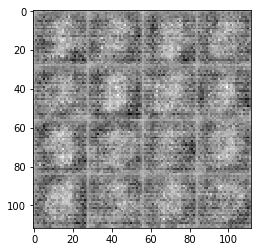

Epoch 1/2...batch 21. d_train_loss: 2.3114.... g_train_loss: 0.8559....
Epoch 1/2...batch 22. d_train_loss: 2.5193.... g_train_loss: 1.5656....
Epoch 1/2...batch 23. d_train_loss: 2.4729.... g_train_loss: 0.4736....
Epoch 1/2...batch 24. d_train_loss: 4.9447.... g_train_loss: 6.9157....
Epoch 1/2...batch 25. d_train_loss: 1.9592.... g_train_loss: 0.4518....
Epoch 1/2...batch 26. d_train_loss: 1.7206.... g_train_loss: 2.4426....
Epoch 1/2...batch 27. d_train_loss: 2.6854.... g_train_loss: 0.3069....
Epoch 1/2...batch 28. d_train_loss: 2.8649.... g_train_loss: 3.7215....
Epoch 1/2...batch 29. d_train_loss: 2.7244.... g_train_loss: 0.2511....
Epoch 1/2...batch 30. d_train_loss: 2.4615.... g_train_loss: 3.5659....
Epoch 1/2...batch 31. d_train_loss: 2.1398.... g_train_loss: 0.8150....
Epoch 1/2...batch 32. d_train_loss: 2.9177.... g_train_loss: 4.5139....
Epoch 1/2...batch 33. d_train_loss: 2.3393.... g_train_loss: 0.3043....
Epoch 1/2...batch 34. d_train_loss: 2.7943.... g_train_loss: 3.7

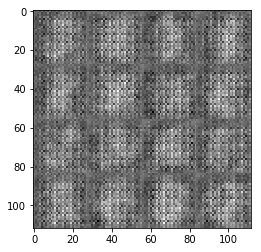

Epoch 1/2...batch 41. d_train_loss: 1.3854.... g_train_loss: 1.3335....
Epoch 1/2...batch 42. d_train_loss: 2.0162.... g_train_loss: 1.3942....
Epoch 1/2...batch 43. d_train_loss: 2.3029.... g_train_loss: 0.5457....
Epoch 1/2...batch 44. d_train_loss: 2.2047.... g_train_loss: 2.8544....
Epoch 1/2...batch 45. d_train_loss: 2.0731.... g_train_loss: 0.3768....
Epoch 1/2...batch 46. d_train_loss: 1.9262.... g_train_loss: 4.1013....
Epoch 1/2...batch 47. d_train_loss: 1.2811.... g_train_loss: 0.7310....
Epoch 1/2...batch 48. d_train_loss: 1.5439.... g_train_loss: 2.7747....
Epoch 1/2...batch 49. d_train_loss: 2.1846.... g_train_loss: 0.6340....
Epoch 1/2...batch 50. d_train_loss: 2.0953.... g_train_loss: 2.1106....
Epoch 1/2...batch 51. d_train_loss: 2.1179.... g_train_loss: 0.4608....
Epoch 1/2...batch 52. d_train_loss: 1.8628.... g_train_loss: 3.1641....
Epoch 1/2...batch 53. d_train_loss: 1.6925.... g_train_loss: 0.6411....
Epoch 1/2...batch 54. d_train_loss: 1.8423.... g_train_loss: 3.5

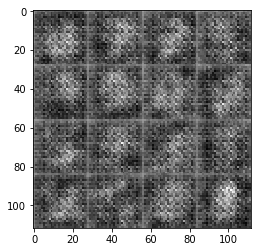

Epoch 1/2...batch 61. d_train_loss: 0.9120.... g_train_loss: 1.4989....
Epoch 1/2...batch 62. d_train_loss: 1.1477.... g_train_loss: 1.8372....
Epoch 1/2...batch 63. d_train_loss: 1.4547.... g_train_loss: 1.2397....
Epoch 1/2...batch 64. d_train_loss: 2.0644.... g_train_loss: 0.4925....
Epoch 1/2...batch 65. d_train_loss: 3.0647.... g_train_loss: 4.3003....
Epoch 1/2...batch 66. d_train_loss: 2.1964.... g_train_loss: 0.3032....
Epoch 1/2...batch 67. d_train_loss: 1.4443.... g_train_loss: 2.2738....
Epoch 1/2...batch 68. d_train_loss: 1.5124.... g_train_loss: 0.6999....
Epoch 1/2...batch 69. d_train_loss: 1.9183.... g_train_loss: 2.5223....
Epoch 1/2...batch 70. d_train_loss: 1.5974.... g_train_loss: 0.6027....
Epoch 1/2...batch 71. d_train_loss: 1.5464.... g_train_loss: 2.5101....
Epoch 1/2...batch 72. d_train_loss: 1.2578.... g_train_loss: 0.9800....
Epoch 1/2...batch 73. d_train_loss: 1.2841.... g_train_loss: 2.3745....
Epoch 1/2...batch 74. d_train_loss: 2.2109.... g_train_loss: 0.4

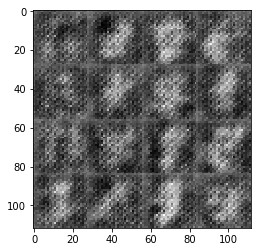

Epoch 1/2...batch 81. d_train_loss: 1.1844.... g_train_loss: 1.2072....
Epoch 1/2...batch 82. d_train_loss: 1.2324.... g_train_loss: 1.7429....
Epoch 1/2...batch 83. d_train_loss: 1.8213.... g_train_loss: 0.6274....
Epoch 1/2...batch 84. d_train_loss: 2.4847.... g_train_loss: 3.4390....
Epoch 1/2...batch 85. d_train_loss: 1.9242.... g_train_loss: 0.4743....
Epoch 1/2...batch 86. d_train_loss: 1.9457.... g_train_loss: 3.0132....
Epoch 1/2...batch 87. d_train_loss: 1.8197.... g_train_loss: 0.6581....
Epoch 1/2...batch 88. d_train_loss: 1.7108.... g_train_loss: 2.4722....
Epoch 1/2...batch 89. d_train_loss: 1.4430.... g_train_loss: 0.8029....
Epoch 1/2...batch 90. d_train_loss: 1.3793.... g_train_loss: 1.5240....
Epoch 1/2...batch 91. d_train_loss: 1.7737.... g_train_loss: 0.6384....
Epoch 1/2...batch 92. d_train_loss: 1.6970.... g_train_loss: 1.2800....
Epoch 1/2...batch 93. d_train_loss: 1.6296.... g_train_loss: 0.7961....
Epoch 1/2...batch 94. d_train_loss: 1.7650.... g_train_loss: 1.4

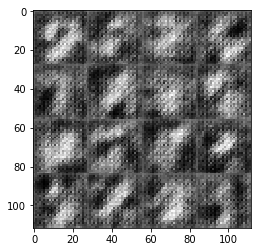

Epoch 1/2...batch 101. d_train_loss: 1.3329.... g_train_loss: 0.9075....
Epoch 1/2...batch 102. d_train_loss: 1.5845.... g_train_loss: 0.8692....
Epoch 1/2...batch 103. d_train_loss: 1.6539.... g_train_loss: 0.8381....
Epoch 1/2...batch 104. d_train_loss: 2.0247.... g_train_loss: 2.7584....
Epoch 1/2...batch 105. d_train_loss: 2.3770.... g_train_loss: 0.3285....
Epoch 1/2...batch 106. d_train_loss: 1.6654.... g_train_loss: 1.8480....
Epoch 1/2...batch 107. d_train_loss: 2.2570.... g_train_loss: 0.6224....
Epoch 1/2...batch 108. d_train_loss: 2.6578.... g_train_loss: 3.2187....
Epoch 1/2...batch 109. d_train_loss: 2.0683.... g_train_loss: 0.6359....
Epoch 1/2...batch 110. d_train_loss: 1.3979.... g_train_loss: 1.4073....
Epoch 1/2...batch 111. d_train_loss: 1.4661.... g_train_loss: 1.7172....
Epoch 1/2...batch 112. d_train_loss: 1.4736.... g_train_loss: 0.7050....
Epoch 1/2...batch 113. d_train_loss: 1.4315.... g_train_loss: 2.2510....
Epoch 1/2...batch 114. d_train_loss: 1.7931.... g_t

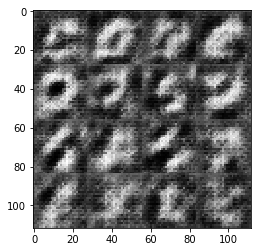

Epoch 1/2...batch 121. d_train_loss: 1.3382.... g_train_loss: 1.7011....
Epoch 1/2...batch 122. d_train_loss: 1.6359.... g_train_loss: 0.3122....
Epoch 1/2...batch 123. d_train_loss: 1.7975.... g_train_loss: 2.7437....
Epoch 1/2...batch 124. d_train_loss: 1.7366.... g_train_loss: 0.6404....
Epoch 1/2...batch 125. d_train_loss: 1.7302.... g_train_loss: 2.5335....
Epoch 1/2...batch 126. d_train_loss: 1.6027.... g_train_loss: 0.4117....
Epoch 1/2...batch 127. d_train_loss: 1.5465.... g_train_loss: 1.7848....
Epoch 1/2...batch 128. d_train_loss: 2.0457.... g_train_loss: 0.5085....
Epoch 1/2...batch 129. d_train_loss: 1.8985.... g_train_loss: 2.1698....
Epoch 1/2...batch 130. d_train_loss: 1.5668.... g_train_loss: 0.6869....
Epoch 1/2...batch 131. d_train_loss: 1.7022.... g_train_loss: 1.3306....
Epoch 1/2...batch 132. d_train_loss: 1.6787.... g_train_loss: 0.4126....
Epoch 1/2...batch 133. d_train_loss: 1.9921.... g_train_loss: 2.3052....
Epoch 1/2...batch 134. d_train_loss: 1.6967.... g_t

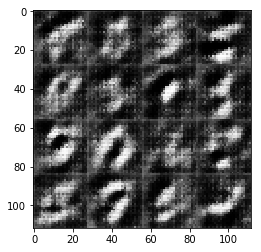

Epoch 1/2...batch 141. d_train_loss: 1.4638.... g_train_loss: 0.7813....
Epoch 1/2...batch 142. d_train_loss: 1.4466.... g_train_loss: 1.6039....
Epoch 1/2...batch 143. d_train_loss: 1.4382.... g_train_loss: 0.6160....
Epoch 1/2...batch 144. d_train_loss: 1.2626.... g_train_loss: 1.4087....
Epoch 1/2...batch 145. d_train_loss: 1.2298.... g_train_loss: 1.2586....
Epoch 1/2...batch 146. d_train_loss: 1.2179.... g_train_loss: 1.1054....
Epoch 1/2...batch 147. d_train_loss: 1.3333.... g_train_loss: 1.6827....
Epoch 1/2...batch 148. d_train_loss: 1.4923.... g_train_loss: 0.7810....
Epoch 1/2...batch 149. d_train_loss: 1.3506.... g_train_loss: 1.5689....
Epoch 1/2...batch 150. d_train_loss: 1.8922.... g_train_loss: 0.5229....
Epoch 1/2...batch 151. d_train_loss: 2.1159.... g_train_loss: 2.5247....
Epoch 1/2...batch 152. d_train_loss: 1.7478.... g_train_loss: 0.5982....
Epoch 1/2...batch 153. d_train_loss: 1.5641.... g_train_loss: 1.4092....
Epoch 1/2...batch 154. d_train_loss: 1.3655.... g_t

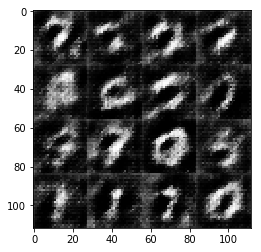

Epoch 1/2...batch 161. d_train_loss: 1.5591.... g_train_loss: 0.6432....
Epoch 1/2...batch 162. d_train_loss: 1.4051.... g_train_loss: 2.1473....
Epoch 1/2...batch 163. d_train_loss: 1.6496.... g_train_loss: 0.5583....
Epoch 1/2...batch 164. d_train_loss: 1.2847.... g_train_loss: 2.0443....
Epoch 1/2...batch 165. d_train_loss: 1.4906.... g_train_loss: 0.8121....
Epoch 1/2...batch 166. d_train_loss: 1.3723.... g_train_loss: 0.9815....
Epoch 1/2...batch 167. d_train_loss: 1.4048.... g_train_loss: 2.0679....
Epoch 1/2...batch 168. d_train_loss: 1.7458.... g_train_loss: 0.6708....
Epoch 1/2...batch 169. d_train_loss: 1.3470.... g_train_loss: 1.6673....
Epoch 1/2...batch 170. d_train_loss: 1.8487.... g_train_loss: 0.6120....
Epoch 1/2...batch 171. d_train_loss: 1.4868.... g_train_loss: 1.7896....
Epoch 1/2...batch 172. d_train_loss: 1.2779.... g_train_loss: 1.2335....
Epoch 1/2...batch 173. d_train_loss: 1.0951.... g_train_loss: 1.5348....
Epoch 1/2...batch 174. d_train_loss: 1.1887.... g_t

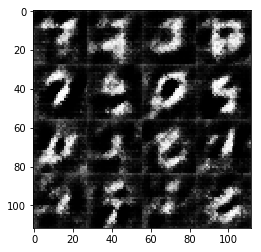

Epoch 1/2...batch 181. d_train_loss: 1.3674.... g_train_loss: 1.3602....
Epoch 1/2...batch 182. d_train_loss: 1.3907.... g_train_loss: 1.2419....
Epoch 1/2...batch 183. d_train_loss: 1.2334.... g_train_loss: 0.9280....
Epoch 1/2...batch 184. d_train_loss: 1.1236.... g_train_loss: 1.3201....
Epoch 1/2...batch 185. d_train_loss: 1.2654.... g_train_loss: 1.3532....
Epoch 1/2...batch 186. d_train_loss: 1.2951.... g_train_loss: 0.8231....
Epoch 1/2...batch 187. d_train_loss: 1.1292.... g_train_loss: 1.5411....
Epoch 1/2...batch 188. d_train_loss: 1.6756.... g_train_loss: 0.7995....
Epoch 1/2...batch 189. d_train_loss: 2.5433.... g_train_loss: 2.5232....
Epoch 1/2...batch 190. d_train_loss: 2.0853.... g_train_loss: 0.3300....
Epoch 1/2...batch 191. d_train_loss: 2.2178.... g_train_loss: 2.9115....
Epoch 1/2...batch 192. d_train_loss: 1.6928.... g_train_loss: 0.3703....
Epoch 1/2...batch 193. d_train_loss: 1.4538.... g_train_loss: 1.8282....
Epoch 1/2...batch 194. d_train_loss: 1.4522.... g_t

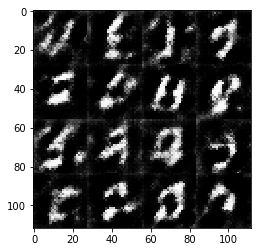

Epoch 1/2...batch 201. d_train_loss: 2.1981.... g_train_loss: 2.7220....
Epoch 1/2...batch 202. d_train_loss: 1.8382.... g_train_loss: 0.4774....
Epoch 1/2...batch 203. d_train_loss: 1.6512.... g_train_loss: 1.9502....
Epoch 1/2...batch 204. d_train_loss: 1.6652.... g_train_loss: 0.4906....
Epoch 1/2...batch 205. d_train_loss: 1.9147.... g_train_loss: 1.9054....
Epoch 1/2...batch 206. d_train_loss: 2.0534.... g_train_loss: 0.3079....
Epoch 1/2...batch 207. d_train_loss: 1.6940.... g_train_loss: 1.8128....
Epoch 1/2...batch 208. d_train_loss: 1.4110.... g_train_loss: 0.7735....
Epoch 1/2...batch 209. d_train_loss: 1.4631.... g_train_loss: 1.7246....
Epoch 1/2...batch 210. d_train_loss: 1.4638.... g_train_loss: 0.7761....
Epoch 1/2...batch 211. d_train_loss: 1.2415.... g_train_loss: 1.0414....
Epoch 1/2...batch 212. d_train_loss: 1.4818.... g_train_loss: 1.3258....
Epoch 1/2...batch 213. d_train_loss: 1.9103.... g_train_loss: 0.4537....
Epoch 1/2...batch 214. d_train_loss: 1.9607.... g_t

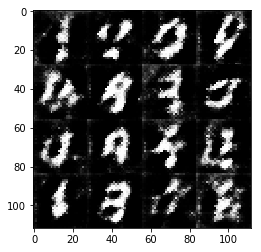

Epoch 1/2...batch 221. d_train_loss: 1.5281.... g_train_loss: 0.5097....
Epoch 1/2...batch 222. d_train_loss: 1.1960.... g_train_loss: 1.0322....
Epoch 1/2...batch 223. d_train_loss: 1.2718.... g_train_loss: 0.8842....
Epoch 1/2...batch 224. d_train_loss: 1.2875.... g_train_loss: 0.6555....
Epoch 1/2...batch 225. d_train_loss: 1.2316.... g_train_loss: 1.3496....
Epoch 1/2...batch 226. d_train_loss: 1.3192.... g_train_loss: 1.0546....
Epoch 1/2...batch 227. d_train_loss: 1.4803.... g_train_loss: 0.7931....
Epoch 1/2...batch 228. d_train_loss: 1.3268.... g_train_loss: 1.4065....
Epoch 1/2...batch 229. d_train_loss: 1.6648.... g_train_loss: 0.4396....
Epoch 1/2...batch 230. d_train_loss: 1.9548.... g_train_loss: 2.5135....
Epoch 1/2...batch 231. d_train_loss: 1.6569.... g_train_loss: 0.5099....
Epoch 1/2...batch 232. d_train_loss: 1.4730.... g_train_loss: 1.9750....
Epoch 1/2...batch 233. d_train_loss: 1.3079.... g_train_loss: 0.9118....
Epoch 1/2...batch 234. d_train_loss: 1.3178.... g_t

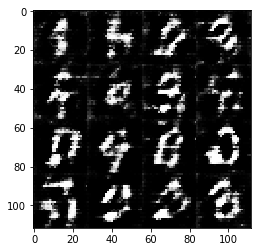

Epoch 1/2...batch 241. d_train_loss: 1.6830.... g_train_loss: 1.4664....
Epoch 1/2...batch 242. d_train_loss: 2.1009.... g_train_loss: 0.4631....
Epoch 1/2...batch 243. d_train_loss: 1.9817.... g_train_loss: 2.5540....
Epoch 1/2...batch 244. d_train_loss: 1.7299.... g_train_loss: 0.4588....
Epoch 1/2...batch 245. d_train_loss: 1.6108.... g_train_loss: 1.8107....
Epoch 1/2...batch 246. d_train_loss: 1.4632.... g_train_loss: 0.6662....
Epoch 1/2...batch 247. d_train_loss: 2.2890.... g_train_loss: 1.9688....
Epoch 1/2...batch 248. d_train_loss: 2.0919.... g_train_loss: 0.2368....
Epoch 1/2...batch 249. d_train_loss: 1.9695.... g_train_loss: 1.5438....
Epoch 1/2...batch 250. d_train_loss: 1.7547.... g_train_loss: 0.5144....
Epoch 1/2...batch 251. d_train_loss: 1.7426.... g_train_loss: 1.4303....
Epoch 1/2...batch 252. d_train_loss: 1.5914.... g_train_loss: 0.5552....
Epoch 1/2...batch 253. d_train_loss: 1.5960.... g_train_loss: 1.1602....
Epoch 1/2...batch 254. d_train_loss: 1.6195.... g_t

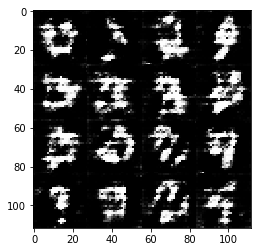

Epoch 1/2...batch 261. d_train_loss: 1.9779.... g_train_loss: 2.3183....
Epoch 1/2...batch 262. d_train_loss: 1.3683.... g_train_loss: 0.6320....
Epoch 1/2...batch 263. d_train_loss: 1.2507.... g_train_loss: 1.7323....
Epoch 1/2...batch 264. d_train_loss: 1.2631.... g_train_loss: 0.6987....
Epoch 1/2...batch 265. d_train_loss: 1.2032.... g_train_loss: 1.2532....
Epoch 1/2...batch 266. d_train_loss: 1.4164.... g_train_loss: 0.8212....
Epoch 1/2...batch 267. d_train_loss: 1.4834.... g_train_loss: 1.4256....
Epoch 1/2...batch 268. d_train_loss: 1.4075.... g_train_loss: 0.7163....
Epoch 1/2...batch 269. d_train_loss: 1.3293.... g_train_loss: 1.0789....
Epoch 1/2...batch 270. d_train_loss: 1.2035.... g_train_loss: 0.9734....
Epoch 1/2...batch 271. d_train_loss: 1.4642.... g_train_loss: 0.9670....
Epoch 1/2...batch 272. d_train_loss: 1.3380.... g_train_loss: 1.1297....
Epoch 1/2...batch 273. d_train_loss: 1.7996.... g_train_loss: 0.6096....
Epoch 1/2...batch 274. d_train_loss: 1.5853.... g_t

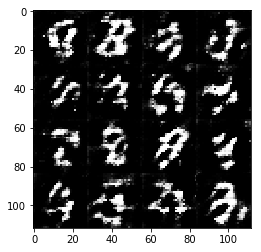

Epoch 1/2...batch 281. d_train_loss: 1.4117.... g_train_loss: 1.4457....
Epoch 1/2...batch 282. d_train_loss: 1.5271.... g_train_loss: 0.6362....
Epoch 1/2...batch 283. d_train_loss: 1.7991.... g_train_loss: 1.4017....
Epoch 1/2...batch 284. d_train_loss: 1.3070.... g_train_loss: 0.7953....
Epoch 1/2...batch 285. d_train_loss: 1.2873.... g_train_loss: 1.4443....
Epoch 1/2...batch 286. d_train_loss: 1.4638.... g_train_loss: 0.6161....
Epoch 1/2...batch 287. d_train_loss: 1.3960.... g_train_loss: 1.3843....
Epoch 1/2...batch 288. d_train_loss: 1.6811.... g_train_loss: 0.7684....
Epoch 1/2...batch 289. d_train_loss: 1.3995.... g_train_loss: 1.2285....
Epoch 1/2...batch 290. d_train_loss: 1.4793.... g_train_loss: 0.6629....
Epoch 1/2...batch 291. d_train_loss: 1.2269.... g_train_loss: 0.9293....
Epoch 1/2...batch 292. d_train_loss: 1.5206.... g_train_loss: 0.7442....
Epoch 1/2...batch 293. d_train_loss: 1.2837.... g_train_loss: 1.1666....
Epoch 1/2...batch 294. d_train_loss: 1.3669.... g_t

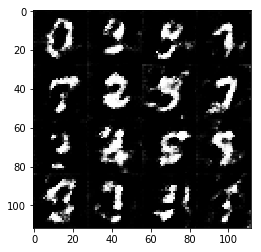

Epoch 1/2...batch 301. d_train_loss: 1.3861.... g_train_loss: 0.6544....
Epoch 1/2...batch 302. d_train_loss: 1.8276.... g_train_loss: 1.6473....
Epoch 1/2...batch 303. d_train_loss: 1.9217.... g_train_loss: 0.4169....
Epoch 1/2...batch 304. d_train_loss: 1.4818.... g_train_loss: 1.6109....
Epoch 1/2...batch 305. d_train_loss: 1.2864.... g_train_loss: 0.9517....
Epoch 1/2...batch 306. d_train_loss: 2.0107.... g_train_loss: 0.4469....
Epoch 1/2...batch 307. d_train_loss: 2.0437.... g_train_loss: 2.5274....
Epoch 1/2...batch 308. d_train_loss: 1.2666.... g_train_loss: 0.6750....
Epoch 1/2...batch 309. d_train_loss: 1.3662.... g_train_loss: 1.0688....
Epoch 1/2...batch 310. d_train_loss: 1.4095.... g_train_loss: 1.1167....
Epoch 1/2...batch 311. d_train_loss: 1.2738.... g_train_loss: 0.8609....
Epoch 1/2...batch 312. d_train_loss: 1.2268.... g_train_loss: 1.1074....
Epoch 1/2...batch 313. d_train_loss: 1.2732.... g_train_loss: 0.9448....
Epoch 1/2...batch 314. d_train_loss: 1.2116.... g_t

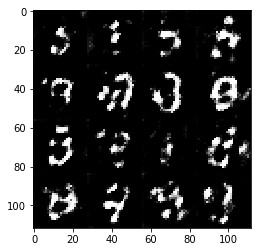

Epoch 1/2...batch 321. d_train_loss: 1.6820.... g_train_loss: 1.3616....
Epoch 1/2...batch 322. d_train_loss: 1.6894.... g_train_loss: 0.4574....
Epoch 1/2...batch 323. d_train_loss: 1.5249.... g_train_loss: 1.5417....
Epoch 1/2...batch 324. d_train_loss: 1.6039.... g_train_loss: 0.3501....
Epoch 1/2...batch 325. d_train_loss: 1.9723.... g_train_loss: 2.5532....
Epoch 1/2...batch 326. d_train_loss: 1.5217.... g_train_loss: 0.8417....
Epoch 1/2...batch 327. d_train_loss: 1.6240.... g_train_loss: 1.5313....
Epoch 1/2...batch 328. d_train_loss: 1.5768.... g_train_loss: 0.5910....
Epoch 1/2...batch 329. d_train_loss: 1.2603.... g_train_loss: 1.1284....
Epoch 1/2...batch 330. d_train_loss: 1.2273.... g_train_loss: 0.6817....
Epoch 1/2...batch 331. d_train_loss: 1.4233.... g_train_loss: 1.1906....
Epoch 1/2...batch 332. d_train_loss: 1.7346.... g_train_loss: 0.5378....
Epoch 1/2...batch 333. d_train_loss: 1.6856.... g_train_loss: 1.2719....
Epoch 1/2...batch 334. d_train_loss: 1.3963.... g_t

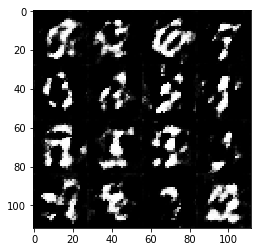

Epoch 1/2...batch 341. d_train_loss: 1.4542.... g_train_loss: 1.0730....
Epoch 1/2...batch 342. d_train_loss: 1.4035.... g_train_loss: 1.1210....
Epoch 1/2...batch 343. d_train_loss: 1.2243.... g_train_loss: 1.2425....
Epoch 1/2...batch 344. d_train_loss: 1.4426.... g_train_loss: 0.7434....
Epoch 1/2...batch 345. d_train_loss: 1.3661.... g_train_loss: 1.0704....
Epoch 1/2...batch 346. d_train_loss: 1.2021.... g_train_loss: 1.1980....
Epoch 1/2...batch 347. d_train_loss: 1.3000.... g_train_loss: 1.2139....
Epoch 1/2...batch 348. d_train_loss: 1.1272.... g_train_loss: 1.3262....
Epoch 1/2...batch 349. d_train_loss: 1.2795.... g_train_loss: 0.9560....
Epoch 1/2...batch 350. d_train_loss: 1.2546.... g_train_loss: 0.8153....
Epoch 1/2...batch 351. d_train_loss: 1.2992.... g_train_loss: 1.8412....
Epoch 1/2...batch 352. d_train_loss: 1.5004.... g_train_loss: 0.7700....
Epoch 1/2...batch 353. d_train_loss: 1.2580.... g_train_loss: 1.3420....
Epoch 1/2...batch 354. d_train_loss: 1.5833.... g_t

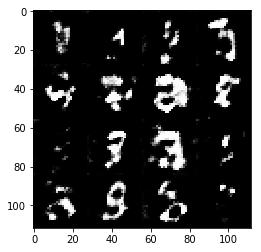

Epoch 1/2...batch 361. d_train_loss: 1.3144.... g_train_loss: 1.5329....
Epoch 1/2...batch 362. d_train_loss: 1.6504.... g_train_loss: 0.5398....
Epoch 1/2...batch 363. d_train_loss: 1.8577.... g_train_loss: 2.2883....
Epoch 1/2...batch 364. d_train_loss: 1.2942.... g_train_loss: 0.7031....
Epoch 1/2...batch 365. d_train_loss: 1.4616.... g_train_loss: 1.5096....
Epoch 1/2...batch 366. d_train_loss: 1.2008.... g_train_loss: 1.0050....
Epoch 1/2...batch 367. d_train_loss: 1.5145.... g_train_loss: 0.8421....
Epoch 1/2...batch 368. d_train_loss: 1.3621.... g_train_loss: 1.0597....
Epoch 1/2...batch 369. d_train_loss: 1.4982.... g_train_loss: 1.2469....
Epoch 1/2...batch 370. d_train_loss: 1.3899.... g_train_loss: 0.6643....
Epoch 1/2...batch 371. d_train_loss: 1.3961.... g_train_loss: 1.3591....
Epoch 1/2...batch 372. d_train_loss: 1.5889.... g_train_loss: 0.5750....
Epoch 1/2...batch 373. d_train_loss: 1.9365.... g_train_loss: 2.1513....
Epoch 1/2...batch 374. d_train_loss: 1.5398.... g_t

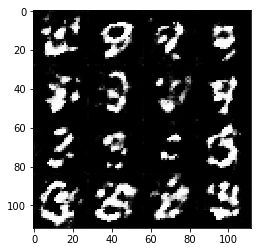

Epoch 1/2...batch 381. d_train_loss: 1.5493.... g_train_loss: 1.0201....
Epoch 1/2...batch 382. d_train_loss: 1.4475.... g_train_loss: 1.1245....
Epoch 1/2...batch 383. d_train_loss: 1.3069.... g_train_loss: 0.8644....
Epoch 1/2...batch 384. d_train_loss: 1.4710.... g_train_loss: 1.2089....
Epoch 1/2...batch 385. d_train_loss: 1.3375.... g_train_loss: 0.8217....
Epoch 1/2...batch 386. d_train_loss: 1.7461.... g_train_loss: 2.5769....
Epoch 1/2...batch 387. d_train_loss: 1.7718.... g_train_loss: 0.3738....
Epoch 1/2...batch 388. d_train_loss: 1.5124.... g_train_loss: 2.0813....
Epoch 1/2...batch 389. d_train_loss: 1.4294.... g_train_loss: 1.0269....
Epoch 1/2...batch 390. d_train_loss: 1.2561.... g_train_loss: 1.3625....
Epoch 1/2...batch 391. d_train_loss: 1.0671.... g_train_loss: 1.2253....
Epoch 1/2...batch 392. d_train_loss: 1.2350.... g_train_loss: 0.9010....
Epoch 1/2...batch 393. d_train_loss: 1.2899.... g_train_loss: 1.5500....
Epoch 1/2...batch 394. d_train_loss: 1.1159.... g_t

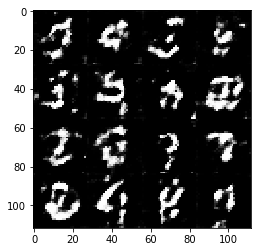

Epoch 1/2...batch 401. d_train_loss: 1.0809.... g_train_loss: 1.4248....
Epoch 1/2...batch 402. d_train_loss: 1.3085.... g_train_loss: 0.5996....
Epoch 1/2...batch 403. d_train_loss: 1.7552.... g_train_loss: 2.4705....
Epoch 1/2...batch 404. d_train_loss: 1.5301.... g_train_loss: 0.6565....
Epoch 1/2...batch 405. d_train_loss: 1.4838.... g_train_loss: 0.7128....
Epoch 1/2...batch 406. d_train_loss: 1.3238.... g_train_loss: 0.7657....
Epoch 1/2...batch 407. d_train_loss: 1.2866.... g_train_loss: 1.3785....
Epoch 1/2...batch 408. d_train_loss: 1.0217.... g_train_loss: 1.3562....
Epoch 1/2...batch 409. d_train_loss: 1.5844.... g_train_loss: 0.8382....
Epoch 1/2...batch 410. d_train_loss: 1.3665.... g_train_loss: 0.9504....
Epoch 1/2...batch 411. d_train_loss: 1.2890.... g_train_loss: 0.5121....
Epoch 1/2...batch 412. d_train_loss: 2.1147.... g_train_loss: 2.3575....
Epoch 1/2...batch 413. d_train_loss: 2.0284.... g_train_loss: 0.2487....
Epoch 1/2...batch 414. d_train_loss: 2.0110.... g_t

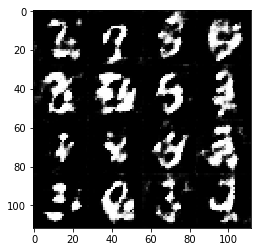

Epoch 1/2...batch 421. d_train_loss: 1.2324.... g_train_loss: 2.0680....
Epoch 1/2...batch 422. d_train_loss: 1.9388.... g_train_loss: 0.3835....
Epoch 1/2...batch 423. d_train_loss: 1.3149.... g_train_loss: 1.4287....
Epoch 1/2...batch 424. d_train_loss: 1.4543.... g_train_loss: 1.1177....
Epoch 1/2...batch 425. d_train_loss: 2.1596.... g_train_loss: 0.5153....
Epoch 1/2...batch 426. d_train_loss: 1.8757.... g_train_loss: 1.4600....
Epoch 1/2...batch 427. d_train_loss: 2.2030.... g_train_loss: 0.2162....
Epoch 1/2...batch 428. d_train_loss: 1.8246.... g_train_loss: 1.2941....
Epoch 1/2...batch 429. d_train_loss: 1.4543.... g_train_loss: 0.8144....
Epoch 1/2...batch 430. d_train_loss: 1.3759.... g_train_loss: 1.0321....
Epoch 1/2...batch 431. d_train_loss: 1.4529.... g_train_loss: 1.1102....
Epoch 1/2...batch 432. d_train_loss: 1.1915.... g_train_loss: 1.4680....
Epoch 1/2...batch 433. d_train_loss: 1.6534.... g_train_loss: 0.5674....
Epoch 1/2...batch 434. d_train_loss: 1.4577.... g_t

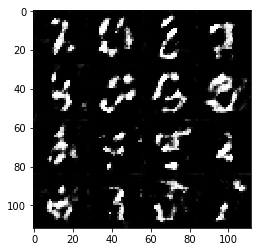

Epoch 1/2...batch 441. d_train_loss: 1.0888.... g_train_loss: 1.0759....
Epoch 1/2...batch 442. d_train_loss: 1.5691.... g_train_loss: 0.8380....
Epoch 1/2...batch 443. d_train_loss: 1.3233.... g_train_loss: 0.9434....
Epoch 1/2...batch 444. d_train_loss: 1.0947.... g_train_loss: 1.4657....
Epoch 1/2...batch 445. d_train_loss: 1.4527.... g_train_loss: 0.5776....
Epoch 1/2...batch 446. d_train_loss: 1.5470.... g_train_loss: 1.3060....
Epoch 1/2...batch 447. d_train_loss: 1.2368.... g_train_loss: 1.1057....
Epoch 1/2...batch 448. d_train_loss: 1.1335.... g_train_loss: 1.3792....
Epoch 1/2...batch 449. d_train_loss: 1.5752.... g_train_loss: 0.6874....
Epoch 1/2...batch 450. d_train_loss: 2.1513.... g_train_loss: 2.1030....
Epoch 1/2...batch 451. d_train_loss: 2.2223.... g_train_loss: 0.2427....
Epoch 1/2...batch 452. d_train_loss: 1.7617.... g_train_loss: 2.2991....
Epoch 1/2...batch 453. d_train_loss: 1.3875.... g_train_loss: 0.5955....
Epoch 1/2...batch 454. d_train_loss: 1.1914.... g_t

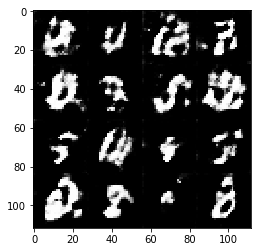

Epoch 1/2...batch 461. d_train_loss: 1.2525.... g_train_loss: 1.3198....
Epoch 1/2...batch 462. d_train_loss: 1.2403.... g_train_loss: 0.8636....
Epoch 1/2...batch 463. d_train_loss: 1.1533.... g_train_loss: 1.5675....
Epoch 1/2...batch 464. d_train_loss: 1.2121.... g_train_loss: 0.9104....
Epoch 1/2...batch 465. d_train_loss: 1.3180.... g_train_loss: 1.2574....
Epoch 1/2...batch 466. d_train_loss: 1.3920.... g_train_loss: 0.7261....
Epoch 1/2...batch 467. d_train_loss: 1.4290.... g_train_loss: 1.8303....
Epoch 1/2...batch 468. d_train_loss: 1.5188.... g_train_loss: 0.6152....
Epoch 1/2...batch 469. d_train_loss: 1.4463.... g_train_loss: 1.0824....
Epoch 1/2...batch 470. d_train_loss: 1.2978.... g_train_loss: 0.8955....
Epoch 1/2...batch 471. d_train_loss: 1.5160.... g_train_loss: 1.8233....
Epoch 1/2...batch 472. d_train_loss: 1.3548.... g_train_loss: 0.7528....
Epoch 1/2...batch 473. d_train_loss: 1.0375.... g_train_loss: 1.0860....
Epoch 1/2...batch 474. d_train_loss: 1.0721.... g_t

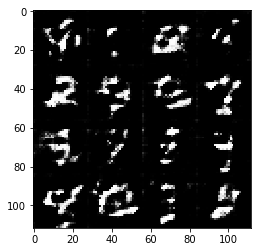

Epoch 1/2...batch 481. d_train_loss: 1.2648.... g_train_loss: 0.7264....
Epoch 1/2...batch 482. d_train_loss: 1.3472.... g_train_loss: 1.1086....
Epoch 1/2...batch 483. d_train_loss: 1.1687.... g_train_loss: 0.8584....
Epoch 1/2...batch 484. d_train_loss: 1.2450.... g_train_loss: 1.8285....
Epoch 1/2...batch 485. d_train_loss: 1.8547.... g_train_loss: 0.3713....
Epoch 1/2...batch 486. d_train_loss: 1.4283.... g_train_loss: 1.5989....
Epoch 1/2...batch 487. d_train_loss: 1.8038.... g_train_loss: 0.4768....
Epoch 1/2...batch 488. d_train_loss: 2.0893.... g_train_loss: 2.1734....
Epoch 1/2...batch 489. d_train_loss: 1.4889.... g_train_loss: 0.6247....
Epoch 1/2...batch 490. d_train_loss: 1.1695.... g_train_loss: 1.1482....
Epoch 1/2...batch 491. d_train_loss: 1.4339.... g_train_loss: 1.4496....
Epoch 1/2...batch 492. d_train_loss: 1.2552.... g_train_loss: 0.9083....
Epoch 1/2...batch 493. d_train_loss: 1.6304.... g_train_loss: 1.3847....
Epoch 1/2...batch 494. d_train_loss: 1.5046.... g_t

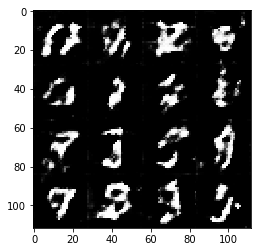

Epoch 1/2...batch 501. d_train_loss: 1.3746.... g_train_loss: 0.9725....
Epoch 1/2...batch 502. d_train_loss: 1.2222.... g_train_loss: 1.1149....
Epoch 1/2...batch 503. d_train_loss: 1.3251.... g_train_loss: 1.0425....
Epoch 1/2...batch 504. d_train_loss: 1.5442.... g_train_loss: 1.8302....
Epoch 1/2...batch 505. d_train_loss: 1.3461.... g_train_loss: 0.8672....
Epoch 1/2...batch 506. d_train_loss: 1.5368.... g_train_loss: 1.5941....
Epoch 1/2...batch 507. d_train_loss: 1.1016.... g_train_loss: 0.9773....
Epoch 1/2...batch 508. d_train_loss: 1.0635.... g_train_loss: 1.3170....
Epoch 1/2...batch 509. d_train_loss: 1.1996.... g_train_loss: 0.6586....
Epoch 1/2...batch 510. d_train_loss: 1.3887.... g_train_loss: 1.5036....
Epoch 1/2...batch 511. d_train_loss: 1.1336.... g_train_loss: 0.8015....
Epoch 1/2...batch 512. d_train_loss: 1.1079.... g_train_loss: 0.7722....
Epoch 1/2...batch 513. d_train_loss: 1.2291.... g_train_loss: 1.2560....
Epoch 1/2...batch 514. d_train_loss: 1.3655.... g_t

KeyboardInterrupt: 

In [14]:
batch_size = 32  # 图像相对较小，只是28 * 28 的黑白色图形, 32/64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5  #  0.5或0.5以下  



"""
Test GANs on MNIST
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  
It will take around 20 minutes on the average GPU to run one epoch.  
You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 16  # 由于包含了许多大图像,16/32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5  # 0.5或0.5以下


"""
Test GANs on celeba 
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'small_img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)